<a href="https://colab.research.google.com/github/DheerajPranav/NewsCategorAI-Unleashing-the-GRUvity/blob/main/News_Category_Prediction_(LSTM).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!gdown 1K-DeiGvzHyLof_UF88yv8H_cFJ8pupBP
!gdown 1Q7gQgJgWRrCDwj9CExv0GI1Kcdsp2pbs

Downloading...
From: https://drive.google.com/uc?id=1K-DeiGvzHyLof_UF88yv8H_cFJ8pupBP
To: /content/TrainDataset.csv
100% 4.04M/4.04M [00:00<00:00, 290MB/s]
Downloading...
From: https://drive.google.com/uc?id=1Q7gQgJgWRrCDwj9CExv0GI1Kcdsp2pbs
To: /content/TestDataset.csv
100% 1.01M/1.01M [00:00<00:00, 154MB/s]


In [ ]:
# !gdown 1ljmjN_-ugZQoj35uXj0joPRUTd3VHBXn

In [ ]:
!pip install pytorch-nlp

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 90 kB 6.4 MB/s 


In [ ]:
!pip install -U spacy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install blitz-bayesian-pytorch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 48 kB 3.6 MB/s 


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torchnlp.encoders.text import SpacyEncoder, pad_tensor
from sklearn.model_selection import train_test_split

import pandas as pd
import numpy as np
from blitz.modules import BayesianEmbedding, BayesianLSTM, BayesianLinear

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from tqdm.notebook import tqdm

In [ ]:
torch.manual_seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(0)

In [ ]:
from nltk.corpus import stopwords
import nltk

nltk.download('stopwords')
stop_words = stopwords.words("english")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
train = pd.read_csv('/content/TrainDataset.csv')
test = pd.read_csv('/content/TestDataset.csv')

X=train.drop('SECTION', axis = 1)
Y=train.drop('STORY', axis = 1)

## Data Cleaning and Pre processing

### step is to create features from our data so we can train the machine learning models. The steps followed are:

# cleaning of extra spaces or lines, lower casing, punctuation signs, possessive pronouns and stop words removal and lemmatization.

#### 1.Removal of extra spaces

for i in [train,test]:
  i['STORY'] = i['STORY'].str.replace("\n", " ")
  i['STORY'] = i['STORY'].str.replace("    ", " ")

# Lowercasing the text

for i in [train,test]:
  i['STORY'] = i['STORY'].str.lower()

#### 3. Removal of punctuations


import string
for i in [train,test]:
  i['STORY']=i['STORY'].str.replace('[{}]'.format(string.punctuation), '')

# " when quoting text
for i in [train,test]:
  i['STORY'] = i['STORY'].str.replace('"', '')

#### 4. Possessive pronouns
# We'll also remove possessive pronoun terminations:

for i in [train,test]:
  i['STORY'] = i['STORY'].str.replace("'s", "")


#### 6. Stop words
for i in stop_words:
    stopw = r"\b" + i + r"\b"
    train['STORY'] = train['STORY'].str.replace(stopw, '')
    stopw= r"\b" + i + r"\b"
    test['STORY'] = test['STORY'].str.replace(stopw, '')

for i in [train,test]:
  i['STORY'] = i['STORY'].str.replace("  ", " ")
  i['STORY'] = i['STORY'].str.replace("   ", " ")
  i['STORY'] = i['STORY'].str.replace("    ", " ")


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:29: FutureWarning: The default value of regex will change from True to False in a future version.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:45: FutureWarning: The default value of regex will change from True to False in a future version.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: FutureWarning: The default value of regex will change from True to False in a future version.


In [ ]:
df = train.copy()
#set names for beautiful df
df.columns = ['text', 'labels']

In [ ]:
df['labels'].value_counts()

1    2224
2    1524
0    1341
3    1013
Name: labels, dtype: int64

In [ ]:
df['labels'].shape

(6102,)

In [ ]:
df['text'].iloc[67]

' platform started 2014  aim providing comfortable digital space people want use internet  mother tongue also firsttime internet users share thoughts emotions opinions become friends others without social stigma language  barrier says sachdeva  usergenerated content platform  40 million monthly active users spread across country  available 14 indian languages—hindi malayalam gujarati marathi punjabi telugu tamil bengali odia kannada assamese haryanvi rajasthani bhojpuri  sharechat app  downloaded  google play store allows users create posts follow people consume types multimedia content interact  people comments share content onto communication platforms  effortless intuitive manner'

In [ ]:
text_as_list = df['text'].tolist()
labels_as_list = df['labels'].tolist()

In [ ]:
from torchnlp.encoders.text import StaticTokenizerEncoder

class SpacyEncoder(StaticTokenizerEncoder):
    """ Encodes the text using spaCy's tokenizer.

    **Tokenizer Reference:**
    https://spacy.io/api/tokenizer

    Args:
        sample (list of strings): Sample of data to build dictionary on
        language (string, optional): Language to use for parsing. Accepted values
            are 'en', 'de', 'es', 'pt', 'fr', 'it', 'nl' and 'xx'.
            For details see https://spacy.io/models/#available-models
        min_occurrences (int, optional): Minimum number of occurrences for a token to be added to
          dictionary.
        append_eos (bool, optional): If `True` append EOS token onto the end to the encoded vector.

    Example:

        >>> encoder = SpacyEncoder(["This ain't funny.", "Don't?"])
        >>> encoder.encode("This ain't funny.")
         5
         6
         7
         8
         9
        [torch.LongTensor of size 5]
        >>> encoder.vocab
        ['<pad>', '<unk>', '</s>', '<s>', '<copy>', 'This', 'ai', "n't", 'funny', '.', 'Do', '?']
        >>> encoder.decode(encoder.encode("This ain't funny."))
        "This ai n't funny ."

    """

    def __init__(self, *args, **kwargs):
        if 'tokenize' in kwargs:
            raise TypeError('SpacyEncoder defines a tokenize callable.')

        try:
            import spacy
        except ImportError:
            print("Please install spaCy: "
                  "`pip install spacy`")
            raise

        # Use English as default when no language was specified
        language = kwargs.get('language', 'en_core_web_sm')

        # All languages supported by spaCy can be found here:
        #   https://spacy.io/models/#available-models
        supported_languages = ['en_core_web_sm', 'de', 'es', 'pt', 'fr', 'it', 'nl', 'xx']

        if language in supported_languages:
            # Load the spaCy language model if it has been installed
            try:
                nlp = spacy.load(language)
            except OSError:
                raise ValueError(("Language '{0}' not found. Install using " +
                                  "spaCy: `python -m spacy download {0}`"
                                  ).format(language))

            from spacy.tokenizer import Tokenizer
            tokenizer = Tokenizer(nlp.vocab)
        else:
            raise ValueError(("No tokenizer available for language '%s'. " +
                              "Currently supported are %s")
                             % (language, supported_languages))

        super().__init__(*args, tokenize=lambda s: [w.text for w in tokenizer(s)], **kwargs)

In [ ]:
%%time
encoder = SpacyEncoder(text_as_list)

CPU times: user 7.76 s, sys: 1.4 s, total: 9.16 s
Wall time: 14.3 s


In [ ]:
%%time
encoded_texts = []
for i in tqdm(range(len(text_as_list))):
    encoded_texts.append(encoder.encode(text_as_list[i]))

  0%|          | 0/6102 [00:00<?, ?it/s]

CPU times: user 1.14 s, sys: 68.2 ms, total: 1.21 s
Wall time: 1.16 s


  0%|          | 0/6102 [00:00<?, ?it/s]

CPU times: user 143 ms, sys: 4.8 ms, total: 148 ms
Wall time: 181 ms


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


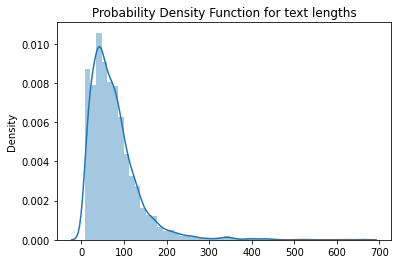

In [ ]:
%%time
lengths = [len(i) for i in tqdm(encoded_texts)]

length_as_series = pd.Series(lengths)
plt.title("Probability Density Function for text lengths")
sns.distplot(length_as_series)


In [ ]:
max_pad_length = length_as_series.quantile(0.9)

In [ ]:
max_pad_length

139.0

In [ ]:
%%time
news = []
labels = []

for i in tqdm(range(len(encoded_texts))):
    if len(encoded_texts[i]) < max_pad_length:
        news.append(encoded_texts[i])
        labels.append(labels_as_list[i])

assert len(news) == len(labels), "The labels and feature lists should have the same time"

  0%|          | 0/6102 [00:00<?, ?it/s]

CPU times: user 53.1 ms, sys: 32 µs, total: 53.1 ms
Wall time: 60.3 ms


In [ ]:
len(labels), len(news)

(5489, 5489)

In [ ]:
%%time
padded_dataset = []
for i in tqdm(range(len(news))):
    padded_dataset.append(pad_tensor(news[i], int(max_pad_length)))

  0%|          | 0/5489 [00:00<?, ?it/s]

CPU times: user 117 ms, sys: 1.8 ms, total: 119 ms
Wall time: 156 ms


In [ ]:
#preparing the final dataset:
X = torch.stack(padded_dataset)
y = torch.tensor(labels)

In [ ]:
X.shape, y.shape

(torch.Size([5489, 139]), torch.Size([5489]))

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=.25,
                                                    random_state=42)

X_train, y_train = torch.tensor(X_train), torch.tensor(y_train)
X_test, y_test = torch.tensor(X_test), torch.tensor(y_test)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys


In [ ]:
len(y_test)

1373

### Custom LSTM [Long Short Term Memory] Algorithm

In [ ]:

import math

class CustomLSTM(nn.Module):
    def __init__(self, input_sz, hidden_sz):
        super().__init__()
        self.input_sz = input_sz
        self.hidden_size = hidden_sz
        self.W = nn.Parameter(torch.Tensor(input_sz, hidden_sz * 4))
        self.U = nn.Parameter(torch.Tensor(hidden_sz, hidden_sz * 4))
        self.bias = nn.Parameter(torch.Tensor(hidden_sz * 4))
        self.init_weights()

    def init_weights(self):
        stdv = 1.0 / math.sqrt(self.hidden_size)
        for weight in self.parameters():
            weight.data.uniform_(-stdv, stdv)

    def forward(self, x,
                init_states=None):
        """Assumes x is of shape (batch, sequence, feature)"""
        bs, seq_sz, _ = x.size()
        hidden_seq = []
        if init_states is None:
            h_t, c_t = (torch.zeros(bs, self.hidden_size).to(x.device),
                        torch.zeros(bs, self.hidden_size).to(x.device))
        else:
            h_t, c_t = init_states

        HS = self.hidden_size
        for t in range(seq_sz):
            x_t = x[:, t, :]
            # batch the computations into a single matrix multiplication
            gates = x_t @ self.W + h_t @ self.U + self.bias
            i_t, f_t, g_t, o_t = (
                torch.sigmoid(gates[:, :HS]), # input
                torch.sigmoid(gates[:, HS:HS*2]), # forget
                torch.tanh(gates[:, HS*2:HS*3]),
                torch.sigmoid(gates[:, HS*3:]), # output
            )
            c_t = f_t * c_t + i_t * g_t
            h_t = o_t * torch.tanh(c_t)
            hidden_seq.append(h_t.unsqueeze(0))
        hidden_seq = torch.cat(hidden_seq, dim=0)
        # reshape from shape (sequence, batch, feature) to (batch, sequence, feature)
        hidden_seq = hidden_seq.transpose(0, 1).contiguous()
        return hidden_seq, (h_t, c_t)

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.embedding = nn.Embedding(len(encoder.vocab)+1, 32)
        self.lstm = CustomLSTM(32,32)#nn.LSTM(32, 32, batch_first=True)
        self.fc1 = nn.Linear(32, 4)

    def forward(self, x):
        x_ = self.embedding(x)
        x_, (h_n, c_n) = self.lstm(x_)
        x_ = (x_[:, -1, :])
        x_ = self.fc1(x_)
        return x_

In [ ]:
ds_train = torch.utils.data.TensorDataset(X_train, y_train)
train_loader = torch.utils.data.DataLoader(ds_train, batch_size=16, shuffle=True)

ds_test = torch.utils.data.TensorDataset(X_test, y_test)
test_loader = torch.utils.data.DataLoader(ds_test, batch_size=32, shuffle=True)

In [ ]:
train_loader.dataset.tensors[0].shape

torch.Size([4116, 139])

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
classifier = Net().to(device)
optimizer = optim.Adam(classifier.parameters(), lr=0.005)#0.002 dives 85% acc
criterion = nn.CrossEntropyLoss()

In [ ]:
epoch_bar = tqdm(range(10),
                 desc="Training",
                 position=0,
                 total=2)

acc = 0
train_acc = 0
prev_acc = 0

total_loss, val_acc = [], []
for epoch in epoch_bar:
    batch_bar = tqdm(enumerate(train_loader),
                     desc="Epoch: {}".format(str(epoch)),
                     position=1,
                     total=len(train_loader))

    for i, (datapoints, labels) in batch_bar:

        optimizer.zero_grad()

        preds = classifier(datapoints.long().to(device))
        loss = criterion(preds, labels.to(device))

        loss.backward()

        optimizer.step()
        #acc = (preds.argmax(dim=1) == labels).float().mean().cpu().item()

        if (i + 1) % 50 == 0:
            acc = 0

            with torch.no_grad():
                for  i, (datapoints_, labels_) in enumerate(test_loader):
                    preds = classifier(datapoints_.to(device))
                    acc += (preds.argmax(dim=1) == labels_.to(device)).float().sum().cpu().item()
            acc /= len(X_test)
            prev_acc = acc

        batch_bar.set_postfix(loss=loss.cpu().item(),
                              accuracy="{:.2f}".format(acc),
                              epoch=epoch)

        batch_bar.update()


    total_loss.append(loss.cpu().item())
    epoch_bar.set_postfix(loss=loss.cpu().item(),
                          accuracy="{:.2f}".format(acc),
                          epoch=epoch)
    if acc not in val_acc:
        val_acc.append(acc)
    epoch_bar.update()

Training:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 0:   0%|          | 0/258 [00:00<?, ?it/s]

Epoch: 1:   0%|          | 0/258 [00:00<?, ?it/s]

Epoch: 2:   0%|          | 0/258 [00:00<?, ?it/s]

Epoch: 3:   0%|          | 0/258 [00:00<?, ?it/s]

Epoch: 4:   0%|          | 0/258 [00:00<?, ?it/s]

Epoch: 5:   0%|          | 0/258 [00:00<?, ?it/s]

Epoch: 6:   0%|          | 0/258 [00:00<?, ?it/s]

Epoch: 7:   0%|          | 0/258 [00:00<?, ?it/s]

Epoch: 8:   0%|          | 0/258 [00:00<?, ?it/s]

Epoch: 9:   0%|          | 0/258 [00:00<?, ?it/s]

In [ ]:
from matplotlib.pylab import plt
from numpy import arange


# Generate a sequence of integers to represent the epoch numbers

def plot_metrics(metrics, label):
  # Plot and label the training and validation loss values
  plt.plot(range(1, len(metrics)+1), metrics, label=label)

  # Add in a title and axes labels
  plt.title(label)
  plt.xlabel('Epochs')
  plt.ylabel(label)

  # Display the plot
  plt.legend(loc='best')
  plt.show()

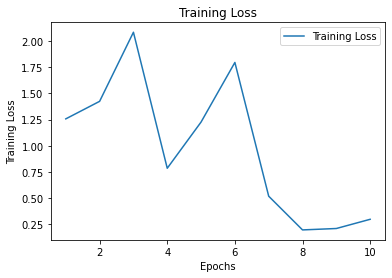

In [ ]:
plot_metrics(total_loss, 'Training Loss')


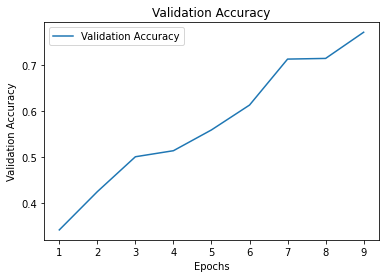

In [ ]:
plot_metrics(val_acc, 'Validation Accuracy')

In [ ]:
#Evaluating Trained model
print(classifier)

Net(
  (embedding): Embedding(38517, 32)
  (lstm): CustomLSTM()
  (fc1): Linear(in_features=32, out_features=4, bias=True)
)


In [ ]:
#Saving and exporting model
torch.save(classifier.state_dict(), 'LSTM-model.pth')

In [ ]:
#Loading and evaluating loaded model
classifier.load_state_dict(torch.load('LSTM-model.pth'))
classifier.eval()

Net(
  (embedding): Embedding(38517, 32)
  (lstm): CustomLSTM()
  (fc1): Linear(in_features=32, out_features=4, bias=True)
)

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

In [ ]:
confusion_matrix(classes, preds)

NameError: ignored

In [ ]:
print(classification_report(classes, preds))

In [ ]:
#Model Testing
inputs, classes = test_loader.dataset.tensors

model = classifier.to(device)
inputs=inputs.to(device)

outputs=model(inputs)
_, preds = torch.max(outputs, 1)
preds=preds.cpu().numpy()
classes=classes.numpy()


In [ ]:
#Calculating accuracy
f=0
for i in range(0,len(preds)):
  if preds[i]==classes[i]:
    f+=1
total=len(preds)
print(f*100/total)


### Custom GRU [Gated Recurrent Units] Algorithm

In [ ]:
from torch.autograd import Variable

class GRUCell(nn.Module):
    def __init__(self, input_size, hidden_size, bias=True):
        super(GRUCell, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.bias = bias

        self.x2h = nn.Linear(input_size, 3 * hidden_size, bias=bias)
        self.h2h = nn.Linear(hidden_size, 3 * hidden_size, bias=bias)

        self.reset_parameters()


    def reset_parameters(self):
        std = 1.0 / np.sqrt(self.hidden_size)
        for w in self.parameters():
            w.data.uniform_(-std, std)

    def forward(self, input, hx=None):

        # Inputs:
        #       input: of shape (batch_size, input_size)
        #       hx: of shape (batch_size, hidden_size)
        # Output:
        #       hy: of shape (batch_size, hidden_size)

        if hx is None:
            hx = Variable(input.new_zeros(input.size(0), self.hidden_size))

        x_t = self.x2h(input)
        h_t = self.h2h(hx)


        x_reset, x_upd, x_new = x_t.chunk(3, 1)
        h_reset, h_upd, h_new = h_t.chunk(3, 1)

        reset_gate = torch.sigmoid(x_reset + h_reset)
        update_gate = torch.sigmoid(x_upd + h_upd)
        new_gate = torch.tanh(x_new + (reset_gate * h_new))

        hy = update_gate * hx + (1 - update_gate) * new_gate

        return hy

In [ ]:
class GRU(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, bias, output_size):
        super(GRU, self).__init__()

        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.bias = bias
        self.output_size = output_size

        self.rnn_cell_list = nn.ModuleList()

        self.rnn_cell_list.append(GRUCell(self.input_size,
                                          self.hidden_size,
                                          self.bias))
        for l in range(1, self.num_layers):
            self.rnn_cell_list.append(GRUCell(self.hidden_size,
                                              self.hidden_size,
                                              self.bias))
        self.fc = nn.Linear(self.hidden_size, self.output_size)


    def forward(self, input, hx=None):

        # Input of shape (batch_size, seqence length, input_size)
        #
        # Output of shape (batch_size, output_size)

        if hx is None:
            if torch.cuda.is_available():
                h0 = Variable(torch.zeros(self.num_layers, input.size(0), self.hidden_size).cuda())
            else:
                h0 = Variable(torch.zeros(self.num_layers, input.size(0), self.hidden_size))

        else:
             h0 = hx

        outs = []

        hidden = list()
        for layer in range(self.num_layers):
            hidden.append(h0[layer, :, :])

        for t in range(input.size(1)):

            for layer in range(self.num_layers):

                if layer == 0:
                    hidden_l = self.rnn_cell_list[layer](input[:, t, :], hidden[layer])
                else:
                    hidden_l = self.rnn_cell_list[layer](hidden[layer - 1],hidden[layer])
                hidden[layer] = hidden_l

                hidden[layer] = hidden_l

            outs.append(hidden_l)

        # Take only last time step. Modify for seq to seq
        out = outs[-1].squeeze()

        out = self.fc(out)

        return out

In [ ]:
class GRU_model(nn.Module):
    def __init__(self):
        super().__init__()
        self.embedding = nn.Embedding(len(encoder.vocab)+1, 32)
        self.gru = GRU(32,32, num_layers=4, bias = True, output_size=4)
        self.fc1 = nn.Linear(32, 4)

    def forward(self, x):
        x_ = self.embedding(x)
        x_ = self.gru(x_)
        # x_ = self.fc1(x_)

        return x_

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
classifier = GRU_model().to(device)
optimizer = optim.Adam(classifier.parameters(), lr=0.005)#0.002 dives 85% acc
criterion = nn.CrossEntropyLoss()

In [ ]:
epoch_bar = tqdm(range(10),
                 desc="Training",
                 position=0,
                 total=2)

acc = 0
train_acc = 0
prev_acc = 0

total_loss, val_acc = [], []
for epoch in epoch_bar:
    batch_bar = tqdm(enumerate(train_loader),
                     desc="Epoch: {}".format(str(epoch)),
                     position=1,
                     total=len(train_loader))

    for i, (datapoints, labels) in batch_bar:

        optimizer.zero_grad()

        preds = classifier(datapoints.long().to(device))
        loss = criterion(preds, labels.to(device))

        loss.backward()

        optimizer.step()
        #acc = (preds.argmax(dim=1) == labels).float().mean().cpu().item()

        if (i + 1) % 50 == 0:
            acc = 0

            with torch.no_grad():
                for  i, (datapoints_, labels_) in enumerate(test_loader):
                    preds = classifier(datapoints_.to(device))
                    acc += (preds.argmax(dim=1) == labels_.to(device)).float().sum().cpu().item()
            acc /= len(X_test)
            prev_acc = acc

        batch_bar.set_postfix(loss=loss.cpu().item(),
                              accuracy="{:.2f}".format(acc),
                              epoch=epoch)

        batch_bar.update()


    total_loss.append(loss.cpu().item())
    epoch_bar.set_postfix(loss=loss.cpu().item(),
                          accuracy="{:.2f}".format(acc),
                          epoch=epoch)
    if acc not in val_acc:
        val_acc.append(acc)
    epoch_bar.update()

In [ ]:
#Saving and exporting model
torch.save(classifier.state_dict(), 'GRU-model.pth')


In [ ]:
#Loading and evaluating loaded model
classifier.load_state_dict(torch.load('GRU-model.pth'))
classifier.eval()

In [ ]:
len(test_loader)

In [ ]:
#Model Testing
inputs, classes = test_loader.dataset.tensors

model = classifier.to(device)
inputs=inputs.to(device)

outputs=model(inputs)
_, preds = torch.max(outputs, 1)
preds=preds.cpu().numpy()
classes=classes.numpy()


In [ ]:
#Calculating accuracy
f=0
for i in range(0,len(preds)):
  if preds[i]==classes[i]:
    f+=1
total=len(preds)
print(f*100/total)


In [ ]:
plot_metrics(total_loss, 'Training Loss')

In [ ]:
plot_metrics(val_acc, 'Validation Accuracy')

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

In [ ]:
confusion_matrix(classes, preds)

In [ ]:
print(classification_report(classes, preds))